In [1]:
import pandas as pd
pd.options.display.max_rows = 100
import numpy as np
import ast
import psutil
from gensim.models import Word2Vec
from tqdm import tqdm
import plotly_express as px

%load_ext autoreload
%load_ext autotime

%autoreload 2
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score
from sklearn import datasets
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import SilhouetteVisualizer

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")


In [2]:
athens_weekdays = pd.read_csv(r"athens_weekdays.csv")
athens_weekends = pd.read_csv(r'athens_weekends.csv')

In [3]:
athens_weekdays.shape

(2653, 20)

In [4]:
athens_weekends.shape

(2627, 20)

In [5]:
merged_df = pd.merge(athens_weekdays, athens_weekends, how='outer')
merged_df.shape

(5280, 20)

In [6]:
merged_df.isnull().sum().sum()

0

In [7]:
merged_df.replace({True: 1, False: 0}, inplace=True)

In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5280 entries, 0 to 5279
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  5280 non-null   int64  
 1   realSum                     5280 non-null   float64
 2   room_type                   5280 non-null   object 
 3   room_shared                 5280 non-null   int64  
 4   room_private                5280 non-null   int64  
 5   person_capacity             5280 non-null   float64
 6   host_is_superhost           5280 non-null   int64  
 7   multi                       5280 non-null   int64  
 8   biz                         5280 non-null   int64  
 9   cleanliness_rating          5280 non-null   float64
 10  guest_satisfaction_overall  5280 non-null   float64
 11  bedrooms                    5280 non-null   int64  
 12  dist                        5280 non-null   float64
 13  metro_dist                  5280 

In [9]:
columns_to_drop = ['attr_index_norm', "rest_index_norm", 'Unnamed: 0', 'multi', 'biz']

In [10]:
merged_df.drop(columns=columns_to_drop, inplace=True)
merged_df.drop(index=4137, inplace=True)

In [11]:
merged_df.shape

(5279, 15)

In [12]:
merged_df_dummies = pd.get_dummies(merged_df, columns=['room_type'], prefix='Category')
merged_df_dummies

,realSum,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat,Category_Entire home/apt,Category_Private room,Category_Shared room
0,129.824479,0,0,4.0,0,10.0,100.0,2,2.813964,0.881890,55.348572,78.778377,23.76600,37.98300,1,0,0
1,138.963748,0,0,4.0,1,10.0,96.0,1,0.407293,0.304568,240.306654,407.167696,23.73168,37.97776,1,0,0
2,156.304923,0,0,3.0,1,10.0,98.0,1,1.237211,0.288488,199.507366,395.967403,23.72200,37.97900,1,0,0
3,91.627024,0,0,4.0,1,10.0,99.0,1,4.367457,0.297467,39.803047,58.706578,23.72712,38.01435,1,0,0
4,74.051508,0,1,2.0,0,10.0,100.0,1,2.194185,0.385266,78.733405,113.325973,23.73391,37.99529,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,74.051508,0,0,3.0,1,10.0,98.0,1,3.311976,1.856865,49.097725,71.119758,23.75000,38.00306,1,0,0
5276,295.737351,0,0,4.0,1,10.0,100.0,1,1.800556,0.571033,146.240703,203.884287,23.71500,37.97400,1,0,0
5277,169.193635,0,0,4.0,1,10.0,99.0,2,3.845100,0.786416,42.260382,60.948754,23.76657,37.99986,1,0,0
5278,160.991728,0,0,4.0,1,10.0,100.0,1,4.827460,0.141952,35.700540,52.659912,23.73300,38.01900,1,0,0


In [13]:
merged_df_dummies.drop(['lng', 'lat'], axis=1, inplace=True)

In [14]:
ss = StandardScaler()

'''fit scaler on numeric features'''
ss.fit(merged_df_dummies)

'''scale numeric features'''
X = ss.transform(merged_df_dummies)
X

array([[-0.08241373, -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ],
       [-0.04804   , -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ],
       [ 0.01718194, -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ],
       ...,
       [ 0.0656577 , -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ],
       [ 0.03480949, -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ],
       [ 0.15291408, -0.0456955 , -0.2851651 , ...,  0.28941499,
        -0.2851651 , -0.0456955 ]])

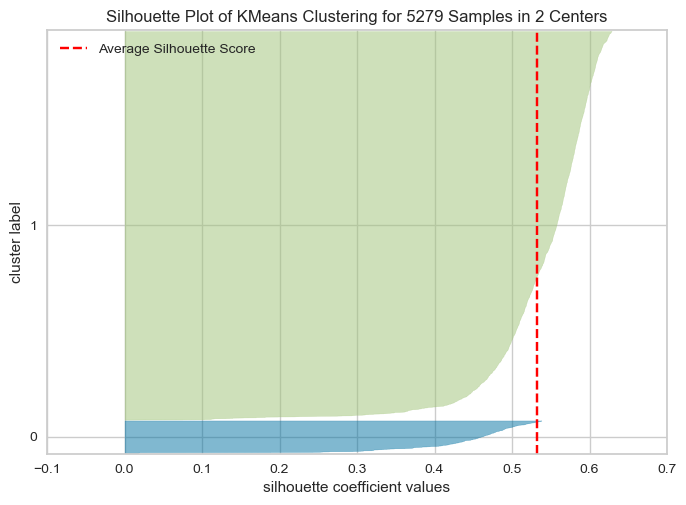

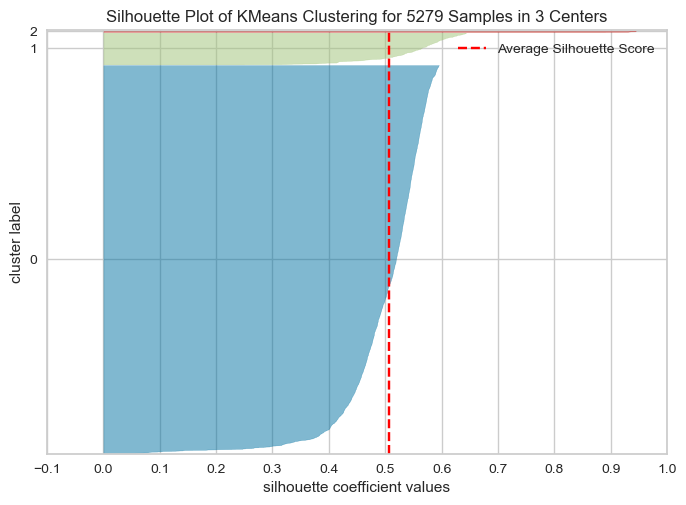

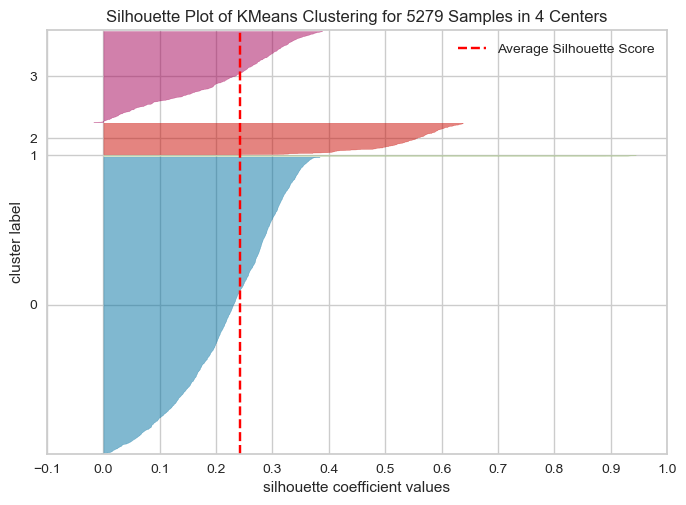

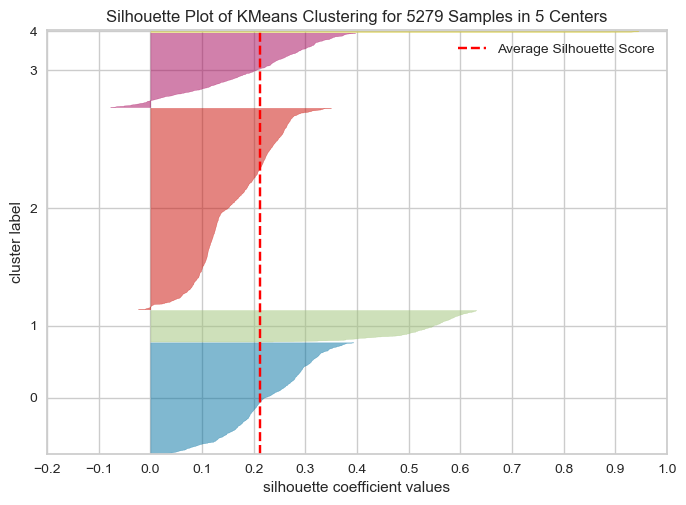

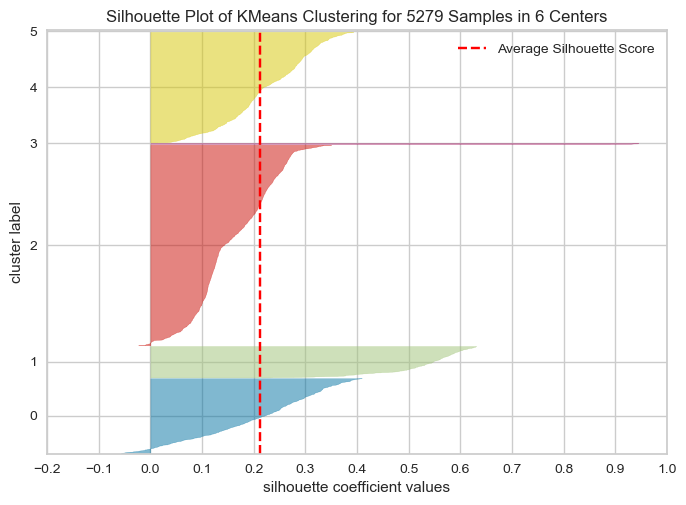

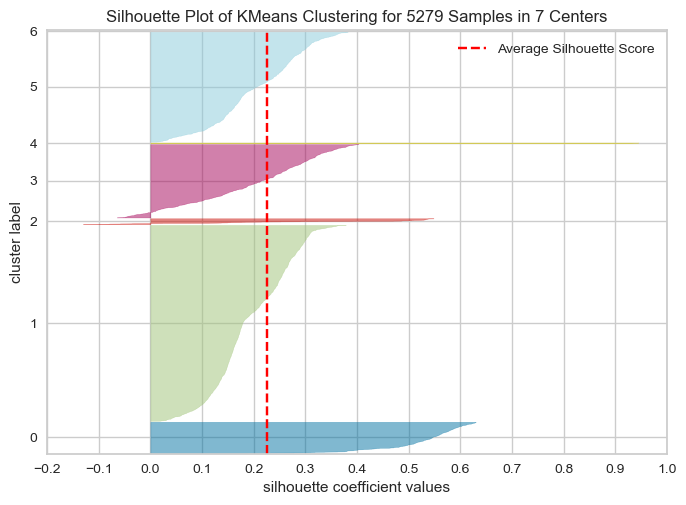

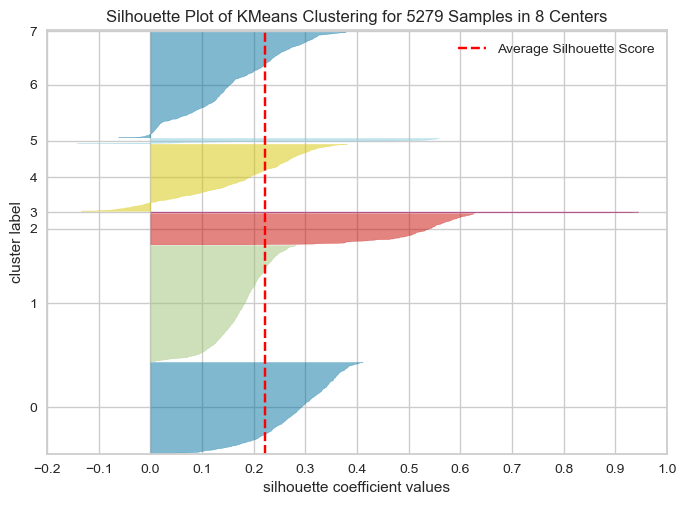

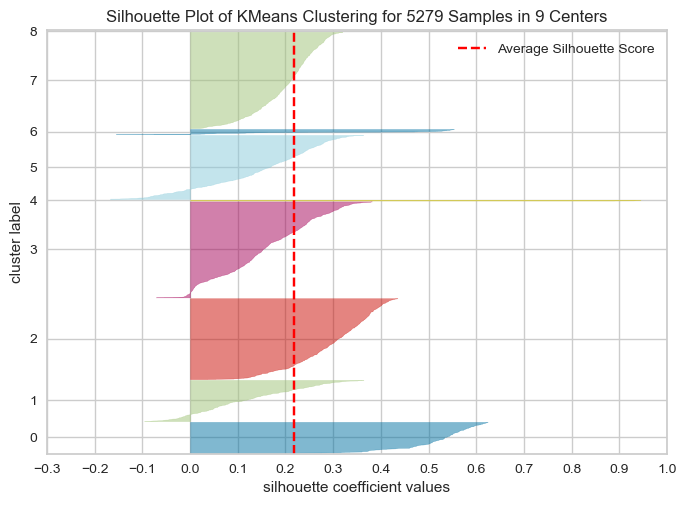

In [15]:
sillhouette_list= []
for i in range(2,10):  
    model_kmeans = KMeans(n_clusters=i, random_state=51).fit(X)
    visualizer = SilhouetteVisualizer(model_kmeans, colors='yellowbrick')
    visualizer.fit(X)
    silhouette_avg = silhouette_score(X, model_kmeans.labels_)
    visualizer.poof()
    sillhouette_list.append(silhouette_avg)

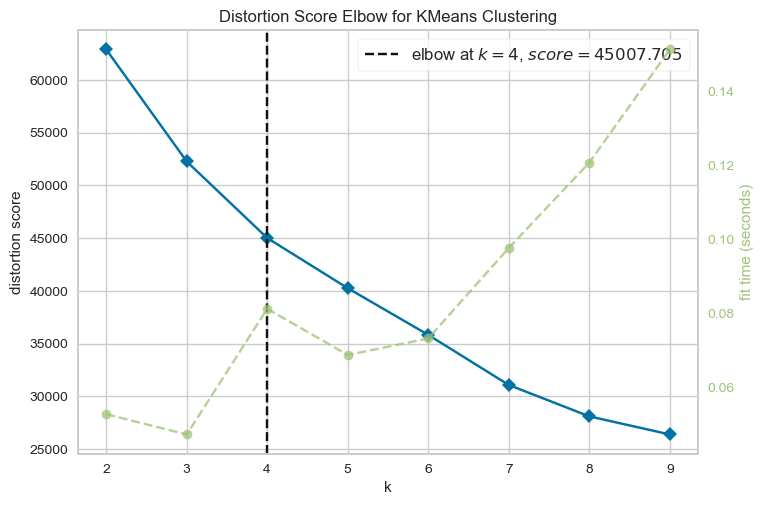

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), timings = True)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

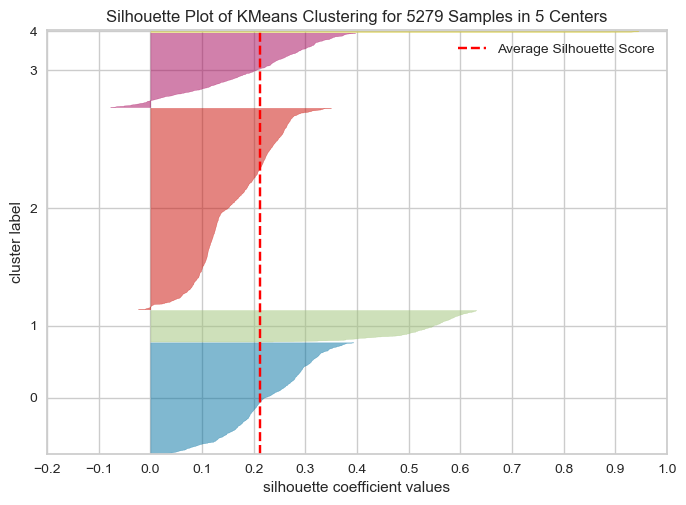

In [17]:
model_kmeans = KMeans(n_clusters=5, random_state=51).fit(X)
visualizer = SilhouetteVisualizer(model_kmeans, colors='yellowbrick')
visualizer.fit(X)
silhouette_avg = silhouette_score(X, model_kmeans.labels_)
visualizer.poof()
sillhouette_list.append(silhouette_avg)

In [18]:
df_predict = model_kmeans.predict(X)

In [19]:
merged_df['Clusters'] = df_predict

In [20]:
merged_df

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat,Clusters
0,129.824479,Entire home/apt,0,0,4.0,0,10.0,100.0,2,2.813964,0.881890,55.348572,78.778377,23.76600,37.98300,0
1,138.963748,Entire home/apt,0,0,4.0,1,10.0,96.0,1,0.407293,0.304568,240.306654,407.167696,23.73168,37.97776,3
2,156.304923,Entire home/apt,0,0,3.0,1,10.0,98.0,1,1.237211,0.288488,199.507366,395.967403,23.72200,37.97900,3
3,91.627024,Entire home/apt,0,0,4.0,1,10.0,99.0,1,4.367457,0.297467,39.803047,58.706578,23.72712,38.01435,2
4,74.051508,Private room,0,1,2.0,0,10.0,100.0,1,2.194185,0.385266,78.733405,113.325973,23.73391,37.99529,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,74.051508,Entire home/apt,0,0,3.0,1,10.0,98.0,1,3.311976,1.856865,49.097725,71.119758,23.75000,38.00306,2
5276,295.737351,Entire home/apt,0,0,4.0,1,10.0,100.0,1,1.800556,0.571033,146.240703,203.884287,23.71500,37.97400,2
5277,169.193635,Entire home/apt,0,0,4.0,1,10.0,99.0,2,3.845100,0.786416,42.260382,60.948754,23.76657,37.99986,0
5278,160.991728,Entire home/apt,0,0,4.0,1,10.0,100.0,1,4.827460,0.141952,35.700540,52.659912,23.73300,38.01900,2


In [21]:
merged_df.groupby('Clusters').median().reset_index()

,Clusters,realSum,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat
0,0,145.993954,0.0,0.0,5.0,0.0,10.0,98.0,2.0,1.857719,0.443380,105.094491,150.178934,23.73038,37.98304
1,1,80.144354,0.0,1.0,2.0,0.0,10.0,96.0,1.0,1.722529,0.408580,111.202037,168.708482,23.72816,37.98498
2,2,111.311602,0.0,0.0,3.0,0.0,10.0,97.0,1.0,1.852878,0.449224,106.846847,153.096687,23.73261,37.98244
3,3,191.455956,0.0,0.0,4.0,1.0,10.0,98.0,1.0,0.910093,0.329189,303.130398,477.096130,23.72844,37.97400
4,4,83.425117,1.0,0.0,2.0,0.0,9.0,94.0,1.0,2.094350,0.250314,110.913696,192.280361,23.71244,37.98037


In [22]:
merged_df_dummies['Clusters']= df_predict

In [23]:
merged_df_dummies.groupby('Clusters').median().reset_index()

,Clusters,realSum,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,Category_Entire home/apt,Category_Private room,Category_Shared room
0,0,145.993954,0.0,0.0,5.0,0.0,10.0,98.0,2.0,1.857719,0.443380,105.094491,150.178934,1.0,0.0,0.0
1,1,80.144354,0.0,1.0,2.0,0.0,10.0,96.0,1.0,1.722529,0.408580,111.202037,168.708482,0.0,1.0,0.0
2,2,111.311602,0.0,0.0,3.0,0.0,10.0,97.0,1.0,1.852878,0.449224,106.846847,153.096687,1.0,0.0,0.0
3,3,191.455956,0.0,0.0,4.0,1.0,10.0,98.0,1.0,0.910093,0.329189,303.130398,477.096130,1.0,0.0,0.0
4,4,83.425117,1.0,0.0,2.0,0.0,9.0,94.0,1.0,2.094350,0.250314,110.913696,192.280361,0.0,0.0,1.0


In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=51)
tsne_X = tsne.fit_transform(X)
tsne_df = pd.DataFrame(tsne_X, columns=['t-SNE1', 't-SNE2', 't-SNE3'])
tsne_df['Target'] = df_predict


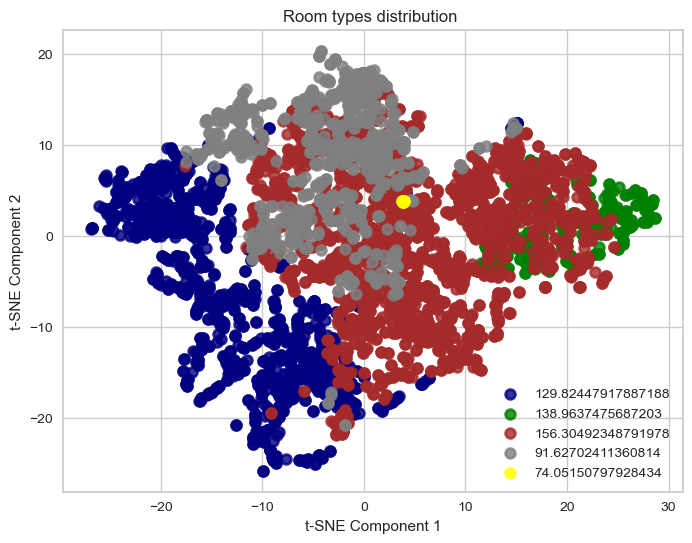

In [25]:
##Create a figure and an axes object
#fig_tsne, ax_tsne = plt.subplots(figsize=(8, 6))
#colors = ['navy', 'green', 'brown','grey','yellow']
#lw = 2 #line width
#
##Plot on the axes object instead of using plt directly
#for color ,i, target_name in zip(colors, [0, 1, 2,3,4], merged_df_dummies.realSum):
#    ax_tsne.scatter(tsne_df.loc[tsne_df['Target'] == i, 't-SNE1'],
#                    tsne_df.loc[tsne_df['Target'] == i, 't-SNE2'],
#                    color=color, alpha=.8, lw=lw,
#                    label=target_name)
#
#ax_tsne.legend(loc='best', shadow=False, scatterpoints=1)
#ax_tsne.set_title('Room types distribution ')
#ax_tsne.set_xlabel('t-SNE Component 1')
#ax_tsne.set_ylabel('t-SNE Component 2')
#
##Save the figure to a variable
#tsne_plot = fig_tsne

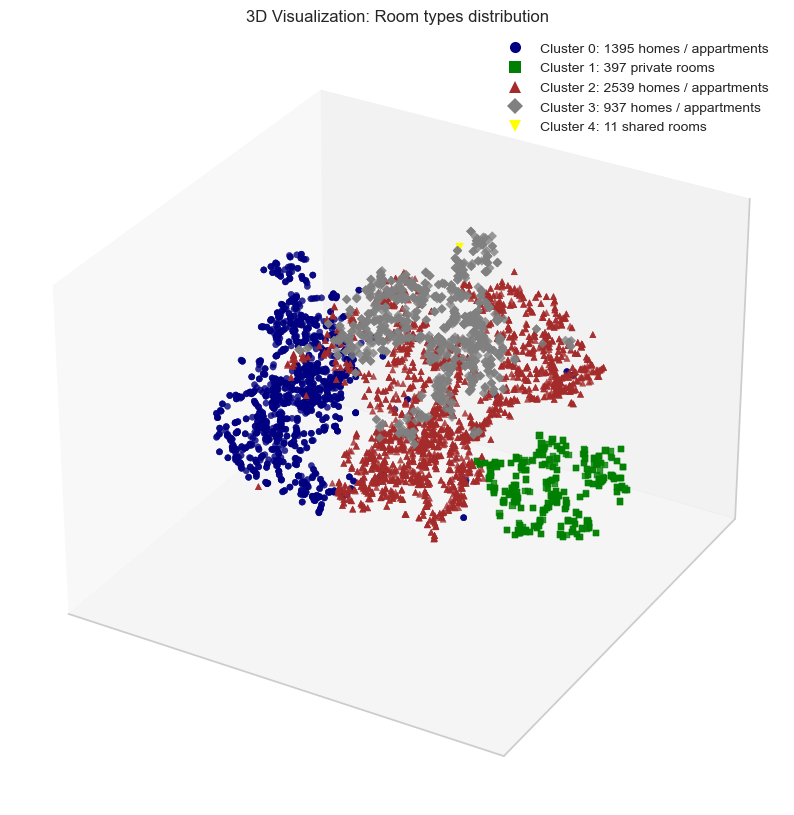

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the Axes3D module

# Assuming you have a DataFrame 'tsne_df' with columns 't-SNE1', 't-SNE2', 't-SNE3', and 'Target'
# 'Target' represents the target category

# Create a figure and an Axes3D object
fig_tsne_3d = plt.figure(figsize=(10, 30))
ax_tsne_3d = fig_tsne_3d.add_subplot(111, projection='3d')

# Define colors and markers for each target category
colors = ['navy', 'green', 'brown', 'grey', 'yellow']
markers = ['o', 's', '^', 'D', 'v']

# Plot on the 3D axes
for color, marker, i, target_name in zip(colors, markers, [0, 1, 2, 3, 4], merged_df_dummies.realSum):
    ax_tsne_3d.scatter(tsne_df.loc[tsne_df['Target'] == i, 't-SNE1'],
                       tsne_df.loc[tsne_df['Target'] == i, 't-SNE2'],
                       tsne_df.loc[tsne_df['Target'] == i, 't-SNE3'],
                       color=color, alpha=0.8, marker=marker,
                       label=target_name)

# Set plot title and labels
ax_tsne_3d.set_title('3D Visualization: Room types distribution')
ax_tsne_3d.set_xticks([])
ax_tsne_3d.set_yticks([])
ax_tsne_3d.set_zticks([])


# Add a custom legend
custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='navy', markersize=8),
                 plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=8),
                 plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='brown', markersize=8),
                 plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='grey', markersize=8),
                 plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='yellow', markersize=8)]

ax_tsne_3d.legend(custom_legend, ['Cluster 0: 1395 homes / appartments ', 'Cluster 1: 397 private rooms ', 'Cluster 2: 2539 homes / appartments', 'Cluster 3: 937 homes / appartments', 'Cluster 4: 11 shared rooms'], loc='best')

# Show the 3D plot
plt.show()

In [69]:
merged_df_dummies.groupby('Clusters').median().reset_index()

,Clusters,realSum,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,Category_Entire home/apt,Category_Private room,Category_Shared room
0,0,145.993954,0.0,0.0,5.0,0.0,10.0,98.0,2.0,1.857719,0.443380,105.094491,150.178934,1.0,0.0,0.0
1,1,80.144354,0.0,1.0,2.0,0.0,10.0,96.0,1.0,1.722529,0.408580,111.202037,168.708482,0.0,1.0,0.0
2,2,111.311602,0.0,0.0,3.0,0.0,10.0,97.0,1.0,1.852878,0.449224,106.846847,153.096687,1.0,0.0,0.0
3,3,191.455956,0.0,0.0,4.0,1.0,10.0,98.0,1.0,0.910093,0.329189,303.130398,477.096130,1.0,0.0,0.0
4,4,83.425117,1.0,0.0,2.0,0.0,9.0,94.0,1.0,2.094350,0.250314,110.913696,192.280361,0.0,0.0,1.0


In [35]:
merged_df_dummies.groupby('Clusters')['room_private'].count().reset_index()

,Clusters,room_private
0,0,1395
1,1,397
2,2,2539
3,3,937
4,4,11


In [43]:
merged_df.columns

Index(['realSum', 'room_type', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'cleanliness_rating',
       'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist',
       'attr_index', 'rest_index', 'lng', 'lat', 'Clusters'],
      dtype='object')

In [32]:
merged_df_dummies.groupby('Clusters').median().reset_index()

,Clusters,realSum,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,Category_Entire home/apt,Category_Private room,Category_Shared room
0,0,145.993954,0.0,0.0,5.0,0.0,10.0,98.0,2.0,1.857719,0.443380,105.094491,150.178934,1.0,0.0,0.0
1,1,80.144354,0.0,1.0,2.0,0.0,10.0,96.0,1.0,1.722529,0.408580,111.202037,168.708482,0.0,1.0,0.0
2,2,111.311602,0.0,0.0,3.0,0.0,10.0,97.0,1.0,1.852878,0.449224,106.846847,153.096687,1.0,0.0,0.0
3,3,191.455956,0.0,0.0,4.0,1.0,10.0,98.0,1.0,0.910093,0.329189,303.130398,477.096130,1.0,0.0,0.0
4,4,83.425117,1.0,0.0,2.0,0.0,9.0,94.0,1.0,2.094350,0.250314,110.913696,192.280361,0.0,0.0,1.0


In [42]:
merged_df

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat,Clusters
0,129.824479,Entire home/apt,0,0,4.0,0,10.0,100.0,2,2.813964,0.881890,55.348572,78.778377,23.76600,37.98300,0
1,138.963748,Entire home/apt,0,0,4.0,1,10.0,96.0,1,0.407293,0.304568,240.306654,407.167696,23.73168,37.97776,3
2,156.304923,Entire home/apt,0,0,3.0,1,10.0,98.0,1,1.237211,0.288488,199.507366,395.967403,23.72200,37.97900,3
3,91.627024,Entire home/apt,0,0,4.0,1,10.0,99.0,1,4.367457,0.297467,39.803047,58.706578,23.72712,38.01435,2
4,74.051508,Private room,0,1,2.0,0,10.0,100.0,1,2.194185,0.385266,78.733405,113.325973,23.73391,37.99529,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,74.051508,Entire home/apt,0,0,3.0,1,10.0,98.0,1,3.311976,1.856865,49.097725,71.119758,23.75000,38.00306,2
5276,295.737351,Entire home/apt,0,0,4.0,1,10.0,100.0,1,1.800556,0.571033,146.240703,203.884287,23.71500,37.97400,2
5277,169.193635,Entire home/apt,0,0,4.0,1,10.0,99.0,2,3.845100,0.786416,42.260382,60.948754,23.76657,37.99986,0
5278,160.991728,Entire home/apt,0,0,4.0,1,10.0,100.0,1,4.827460,0.141952,35.700540,52.659912,23.73300,38.01900,2


In [48]:
merged_df.groupby('host_is_superhost')['guest_satisfaction_overall'].mean().reset_index()

,host_is_superhost,guest_satisfaction_overall
0,0,93.133908
1,1,97.496021


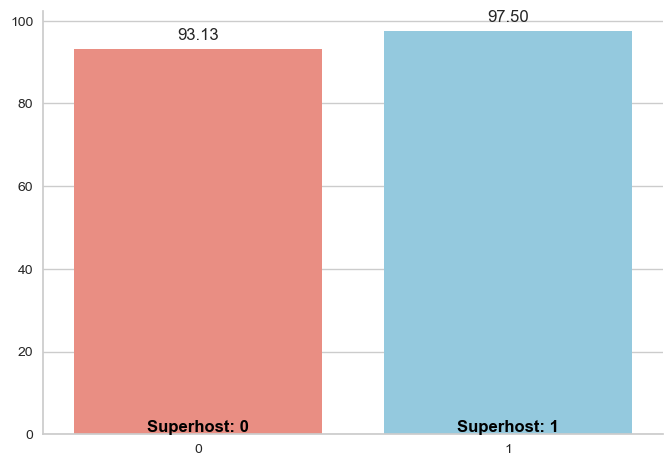

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'mean_satisfaction' with columns 'host_is_superhost' and 'guest_satisfaction_overall'

# Define custom colors for the bars
custom_palette = {'1': 'skyblue', '0': 'salmon'}

# Create a bar plot using Seaborn and capture the axes object
ax = sns.barplot(x='host_is_superhost', y='guest_satisfaction_overall', data=mean_satisfaction, palette=custom_palette)

# Set plot title and labels
plt.title('')
plt.xlabel('')
plt.ylabel('')

# Add labels and values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add labels indicating superhost status
for i, p in enumerate(ax.patches):
    ax.text(p.get_x() + p.get_width() / 2., 0, f'Superhost: {mean_satisfaction["host_is_superhost"].iloc[i]}',
            ha='center', va='bottom', color='black', weight='bold')

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()

In [77]:
mean_satisfaction

,host_is_superhost,guest_satisfaction_overall
0,0,93.133908
1,1,97.496021


In [90]:
attr = merged_df_dummies.groupby('Clusters')['attr_index'].mean().reset_index()
attr

,Clusters,attr_index
0,0,109.807639
1,1,137.912141
2,2,107.805963
3,3,341.949555
4,4,151.653892


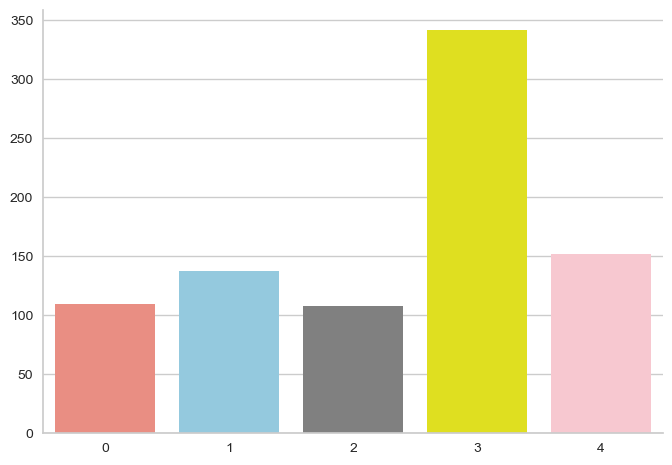

In [96]:
mean_attr_index_by_clusters = merged_df_dummies.groupby('Clusters')['attr_index'].mean().reset_index()
custom_palette = {'1': 'skyblue', '0': 'salmon' , "2": 'grey', '3': 'yellow', '4': 'pink'}
# Create a bar plot using Seaborn
sns.barplot(x='Clusters', y='attr_index', data=mean_attr_index_by_clusters, palette =custom_palette)

# Set plot title and labels
plt.title('')
plt.xlabel('')
plt.ylabel('')
sns.despine()
# Show the plot
plt.show()

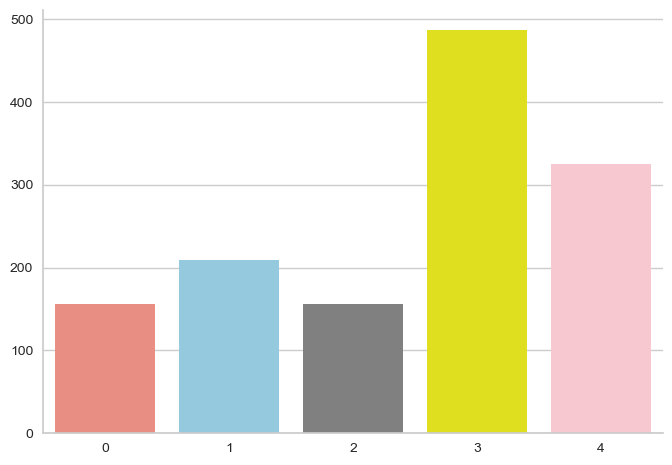

In [98]:
mean_attr_index_by_clusters = merged_df_dummies.groupby('Clusters')['rest_index'].mean().reset_index()
custom_palette = {'1': 'skyblue', '0': 'salmon' , "2": 'grey', '3': 'yellow', '4': 'pink'}
# Create a bar plot using Seaborn
sns.barplot(x='Clusters', y='rest_index', data=mean_attr_index_by_clusters, palette =custom_palette)

# Set plot title and labels
plt.title('')
plt.xlabel('')
plt.ylabel('')
sns.despine()
# Show the plot
plt.show()